In [1]:
import tensorflow as tf
import keras

print("Tensorflow version: {}, Keras version: {}".format(tf.__version__, keras.__version__))

Tensorflow version: 2.8.0, Keras version: 2.7.0


In [2]:
import os
import json
import yaml
import pickle
import string
import requests
import zipfile
import pandas as pd
import numpy as np

from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Input, Dense, GRU, LSTM, Embedding
from tensorflow.python.keras.optimizers import adam_v2

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelBinarizer

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from mosestokenizer import MosesDetokenizer

import spacy
from spacy.lang.en import STOP_WORDS

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anurags/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/anurags/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
nlp = spacy.load('en_core_web_sm')
lemmatizer = WordNetLemmatizer()
detokenizer = MosesDetokenizer('en')
translator = str.maketrans('', '', string.punctuation)

In [6]:
# Reduce stopwords list by excluding these words from the list.
not_stopwords = [
    'no', 'not', 'to', 'i', 'be', 'how', 'are', 'r', 'y', 'you', 'the', 'do', 'what', 'up', 'can', 'for',
    'of', 'where', 'have', 'who', 'on', 'with', 'which', 'in', 'about', 'at', 'will', 'here', 'too', 'off',
    'before', 'why'
]

NLTK_STOPWORDS = set(stopwords.words("english"))


def get_stopwords(stopwords, not_stopwords):
    for word in not_stopwords:
        stopwords.discard(word)
    return stopwords


custom_stopwords = get_stopwords(NLTK_STOPWORDS, not_stopwords=not_stopwords)

print(custom_stopwords)

{'further', 'yourselves', 'doing', 'he', 'mustn', 'them', 'your', 'having', 'don', 'doesn', 'am', "doesn't", 'my', 'won', 'theirs', 'down', 'all', 'didn', 'more', "wasn't", 'other', 'while', "it's", 'our', 'being', 'by', 'does', 'so', "shouldn't", 'isn', 'against', 'just', 'themselves', 'yourself', 'an', 'than', 'most', 'or', 'll', 'below', 'we', 'again', 'only', 'should', 'shan', 'above', 've', "aren't", 'herself', 'him', 'ourselves', "needn't", 'ours', 'yours', 'himself', 'haven', "don't", 'out', 'had', 'each', 'hers', 'wasn', 'and', "wouldn't", 'same', 'between', 'these', "you'll", 'they', 'needn', 'own', 'very', 'over', 'wouldn', 'both', 'm', "mightn't", 'did', 'is', 's', 'ma', 'o', "you'd", 'few', 'now', 'any', 'but', 'after', "mustn't", 'weren', 'from', 'as', 'this', 'myself', 'some', 'a', "weren't", "didn't", 're', "couldn't", 'her', 'has', 'mightn', 'aren', "you've", 'until', 'its', "hasn't", 'because', 'that', "haven't", 'his', 'ain', 'when', 'd', 'she', 'couldn', 'it', 'hasn'

### Loading the Data

In [7]:
DATA_FOLDER = "./data"

dataset_url = "https://www.kaggle.com/elvinagammed/chatbots-intent-recognition-dataset/"

# INTENT_FILE_NAME = "Intent.json"
INTENT_FILE_NAME = "intents.yml"

INTENT_DATA_FOLDER = os.path.join(os.path.join(DATA_FOLDER, "Intent"))
INTENT_FILE_PATH = os.path.join(INTENT_DATA_FOLDER, INTENT_FILE_NAME)
print(INTENT_FILE_PATH)

./data/Intent/intents.yml


In [8]:
intent_data = None
with open(INTENT_FILE_PATH, 'r') as f:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    intent_data = yaml.full_load(f)
    intent_data = intent_data["intents"]

display(intent_data[:5])

[{'intent': 'greet',
  'examples': "- hey\n- hello\n- hi\n- hello there\n- good morning\n- good evening\n- moin\n- hey there\n- let's go\n- hey dude\n- goodmorning\n- goodevening\n- good afternoon\n- Hellllooooooo\n- howdy\n- hey bot\n- heya\n- Hallo\n- hello?\n- ayyyy whaddup\n- heyo\n- helloooo\n- hellooo\n- hello sweatheart\n- hiihihi\n- hey there\n- yoo\n- hello sweet boy\n- whats up\n- Hei\n- hello\n- I said, helllllloooooO!!!!\n- good evening\n- hi there it's me\n- hi friend\n- jop\n- hi\n- hi there\n- what up\n- hii\n- hello it is me again\n- jojojo\n- hey let's talk\n- hey, let's talk\n- heyho\n- hiii\n- Whats up my bot\n- Heya\n- hey dude\n- Well hello there\n- hello friend\n- Hey\n- greetings\n- hello everybody\n- hello is anybody there\n- good afternoon\n- hello robot\n- hallo\n- hi?\n- hola\n- yo\n- heeey\n- hi hi\n- hey\n- hey hey\n- hello there\n- hi\n- hi there\n- hey bot!\n- hi pal!\n- hi folks\n- Hey man\n- Hi\n- Yo!\n- Howdy\n- Yo!\n- Howdy\n- Hiya\n- Hello!\n- Hola!\

In [9]:
train_data = {'text': [], 'intent': []}

for i in range(len(intent_data)):
    lines = intent_data[i]["examples"]
    lines = lines.split("\n")
    lines = [l.strip("- ").strip("''") for l in lines if l.strip()]
    intent_lines = [intent_data[i]["intent"] for _ in range(len(lines))]
    train_data["text"].extend(lines)
    train_data["intent"].extend(intent_lines)

train_data = pd.DataFrame(train_data)
print(len(train_data))
print(train_data.head())

1433
           text intent
0           hey  greet
1         hello  greet
2            hi  greet
3   hello there  greet
4  good morning  greet


In [10]:
x_train = train_data['text'].tolist()
y_train = train_data['intent'].tolist()

### Pre-processing

In [11]:
def remove_punctuation(text):
    return text.translate(translator)


def tokenize_sent(text):
    return word_tokenize(text)


def detokenize_sent(tokenized_text):
    return detokenizer(tokenized_text)


def remove_stopwords(text):
    text = text.lower()
    tokenized_text = tokenize_sent(text)
    cleaned_text = [word for word in tokenized_text if not word in NLTK_STOPWORDS]
    return ' '.join(cleaned_text)


def remove_custom_stopwords(text, stopwords):
    text = text.lower()
    tokenized_text = tokenize_sent(text)
    cleaned_text = [word for word in tokenized_text if not word in stopwords]
    return ' '.join(cleaned_text)


def lower_case_text(text):
    return text.lower()

In [12]:
PADDING = 'pre'
TEXT_LEN_LIMIT = 50

In [13]:
x_train_processed = []

for i in range(len(x_train)):
    # lower case the text
    text = lower_case_text(x_train[i])
    # remove punctuation
    text = text.translate(translator)
    # remove stopwords
    text = remove_custom_stopwords(text, custom_stopwords)

    if not text:
        text = x_train[i]
    # process the text using Spacy's language model "en_core_web_sm".
    doc = nlp(text)
    # lemmatization
    text = [token.lemma_ for token in doc]
    # detokenize text
    text = detokenize_sent(text)

    x_train_processed.append(text)

print(x_train_processed[:5])

['hey', 'hello', 'hi', 'hello', 'good morning']


In [14]:
all_words = []
for i in range(len(x_train_processed)):
    words = word_tokenize(x_train_processed[i])
    all_words.extend(words)

all_words = list(set(all_words))

In [15]:
num_words = len(all_words)

In [16]:
num_intents = len(set(y_train))

In [19]:
# Tokenize Text to assign each word a number
tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(x_train_processed)
print(tokenizer.word_index)

{'i': 1, 'to': 2, 'you': 3, 'the': 4, 'what': 5, 'want': 6, 'be': 7, 'bot': 8, 'how': 9, 'newsletter': 10, 'do': 11, 'about': 12, 's': 13, 'who': 14, 'm': 15, 'can': 16, 'for': 17, 'name': 18, 'time': 19, 'know': 20, 'chatbot': 21, 'not': 22, 'like': 23, 'good': 24, 'in': 25, 'of': 26, 'thank': 27, 'tell': 28, 'build': 29, 'up': 30, 'talk': 31, 'have': 32, 'no': 33, 'please': 34, 'learn': 35, 'give': 36, 'company': 37, 'weather': 38, 'hi': 39, 'go': 40, 'help': 41, 'get': 42, 'one': 43, 'sign': 44, 'subscribe': 45, 'bye': 46, 'day': 47, 'yes': 48, 'stop': 49, 'with': 50, 'hey': 51, 'would': 52, 'work': 53, 'feedback': 54, 'hello': 55, 'today': 56, 'human': 57, 'manager': 58, 'developer': 59, 'make': 60, 'will': 61, 'email': 62, 'on': 63, 'why': 64, 'use': 65, 'cool': 66, 'speak': 67, 'let': 68, 'ok': 69, 'nice': 70, 'sure': 71, 'd': 72, 'start': 73, 'great': 74, 'real': 75, 'else': 76, 'create': 77, 'call': 78, 'learning': 79, 'see': 80, 'accept': 81, 'machine': 82, 'which': 83, 'akela

In [20]:
x_train_tokens = tokenizer.texts_to_sequences(x_train_processed)

In [21]:
max_tokens = 0

for i in range(len(x_train_tokens)):
    if len(x_train_tokens[i]) > max_tokens:
        max_tokens = len(x_train_tokens[i])

max_tokens = min(max_tokens, TEXT_LEN_LIMIT)
print(max_tokens)

16


In [22]:
encoder = LabelBinarizer()

y_train_pad = encoder.fit_transform(y_train)

In [23]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens, padding=PADDING, truncating=PADDING)

In [24]:
print(len(x_train_pad), len(y_train_pad))
print(len((x_train_pad[0])), len((y_train_pad[0])))

1433 1433
16 52


In [32]:
word_index = tokenizer.word_index

inverse_map = dict(zip(word_index.values(), word_index.keys()))

In [26]:
def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]

    # Concatenate all words.
    text = " ".join(words)

    return text

In [27]:
display(x_train_processed[1])
display(x_train_pad[1])

'hello'

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 55],
      dtype=int32)

In [28]:
tokens_to_string(x_train_pad[1])

'hello'

In [29]:
glove_word_vec_download_url = "https://nlp.stanford.edu/data/glove.6B.zip"
print(glove_word_vec_download_url.rsplit("/", 1)[1])
GLOVE_ZIP_PATH = os.path.join(DATA_FOLDER, glove_word_vec_download_url.rsplit("/", 1)[1])
GLOVE_FOLDER_PATH = os.path.join(DATA_FOLDER, glove_word_vec_download_url.rsplit("/", 1)[1].rsplit(".", 1)[0])
GLOVE_FILE = "glove.6B.100d.txt"
GLOVE_VEC_SIZE = 100
print(GLOVE_FOLDER_PATH, GLOVE_ZIP_PATH)

if not os.path.exists(GLOVE_ZIP_PATH):
    req = requests.get(glove_word_vec_download_url, allow_redirects=True)
    # Writing the file to the local file system
    with open(GLOVE_ZIP_PATH, 'wb') as output_file:
        output_file.write(req.content)
    print("Downloaded zip file")
else:
    print("Zip file already present")

if not os.path.exists(GLOVE_FOLDER_PATH):
    with zipfile.ZipFile(GLOVE_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(GLOVE_FOLDER_PATH)
    print("Extracted zip file")
else:
    print("Files already present on disk")

glove.6B.zip
./data/glove.6B ./data/glove.6B.zip
Zip file already present
Files already present on disk


In [30]:
embeddings_index = dict()

with open(os.path.join(GLOVE_FOLDER_PATH, GLOVE_FILE)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(list(embeddings_index.keys())[-10:])

['sigarms', 'katuna', 'aqm', '1.3775', 'corythosaurus', 'chanty', 'kronik', 'rolonda', 'zsombor', 'sandberger']


In [105]:
VOCAB_SIZE = 20000
EMBEDDING_DIM = GLOVE_VEC_SIZE
# BATCH_SIZE = 128
BATCH_SIZE = 64
# BATCH_SIZE = 32

In [106]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    if index > VOCAB_SIZE - 1:
        break

In [107]:
model = Sequential()

text_input = Input(shape=(max_tokens,), name='text_input')

emb_layer = Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=max_tokens, weights=[embedding_matrix],
    trainable=False, name='embedding_layer'
)(text_input)

main_lstm = LSTM(units=num_intents, dropout=0.4, return_sequences=True, name='lstm_1')(emb_layer)

sec_lstm = LSTM(units=num_intents, dropout=0.2, return_sequences=True, name='lstm_2')(main_lstm)

final_lstm = LSTM(units=num_intents, name='last_lstm')(sec_lstm)

out = Dense(num_intents, activation='softmax', name='out')(final_lstm)

model = Model(text_input, out, name="intent_classifier")

model.build(input_shape=(BATCH_SIZE, max_tokens,))

optimizer = adam_v2.Adam(learning_rate=1e-3)

model.compile(
    loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']
)

In [108]:
model.summary()

Model: "intent_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 16)]              0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 16, 100)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 52)            31824     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16, 52)            21840     
_________________________________________________________________
last_lstm (LSTM)             (None, 52)                21840     
_________________________________________________________________
out (Dense)                  (None, 52)                2756      
Total params: 2,078,260
Trainable params: 78,260
Non-trainable params: 2,000,000
__________________________________

In [109]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(x_train_pad, y_train_pad, test_size=0.0)
# # X_train, X_test, y_train, y_test=train_test_split(x_train_pad,y_train_pad,test_size=0.1, stratify=y_train_pad)

In [110]:
X_train, y_train = x_train_pad, y_train_pad

In [111]:
%%time
# epochs ~ 100
EPOCHS = 100
# EPOCHS = 20
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)

Epoch 1/100


2022-03-12 17:36:38.028617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 26s 2s/step - loss: 3.8848 - accuracy: 0.2519
Epoch 2/100
12/12 [==============================] - 23s 2s/step - loss: 3.4615 - accuracy: 0.2903
Epoch 3/100
12/12 [==============================] - 25s 2s/step - loss: 3.1480 - accuracy: 0.2903
Epoch 4/100
12/12 [==============================] - 25s 2s/step - loss: 3.0610 - accuracy: 0.2903
Epoch 5/100
12/12 [==============================] - 26s 2s/step - loss: 3.0233 - accuracy: 0.2903
Epoch 6/100
12/12 [==============================] - 27s 2s/step - loss: 2.9754 - accuracy: 0.2903
Epoch 7/100
12/12 [==============================] - 26s 2s/step - loss: 2.9117 - accuracy: 0.2903
Epoch 8/100
12/12 [==============================] - 25s 2s/step - loss: 2.8566 - accuracy: 0.2875
Epoch 9/100
12/12 [==============================] - 25s 2s/step - loss: 2.8026 - accuracy: 0.2980
Epoch 10/100
12/12 [==============================] - 26s 2s/step - loss: 2.7526 - accuracy: 0.3050
Epoch 11/100
12/12 [=

12/12 [==============================] - 29s 2s/step - loss: 1.1462 - accuracy: 0.6783
Epoch 84/100
12/12 [==============================] - 29s 2s/step - loss: 1.1329 - accuracy: 0.6832
Epoch 85/100
12/12 [==============================] - 27s 2s/step - loss: 1.1365 - accuracy: 0.6818
Epoch 86/100
12/12 [==============================] - 27s 2s/step - loss: 1.1037 - accuracy: 0.7006
Epoch 87/100
12/12 [==============================] - 27s 2s/step - loss: 1.0997 - accuracy: 0.6950
Epoch 88/100
12/12 [==============================] - 28s 2s/step - loss: 1.0958 - accuracy: 0.6916
Epoch 89/100
12/12 [==============================] - 27s 2s/step - loss: 1.0797 - accuracy: 0.6950
Epoch 90/100
12/12 [==============================] - 27s 2s/step - loss: 1.0542 - accuracy: 0.7055
Epoch 91/100
12/12 [==============================] - 26s 2s/step - loss: 1.0552 - accuracy: 0.7083
Epoch 92/100
12/12 [==============================] - 26s 2s/step - loss: 1.0494 - accuracy: 0.7111
Epoch 93/100


### Save Model

In [17]:
MODEL_FOLDER = "./models"
INTENT_MODEL_FOLDER = "intent"
MODEL_SAVE_FOLDER = os.path.join(MODEL_FOLDER, INTENT_MODEL_FOLDER)
TF_MODEL_SAVE_FOLDER = os.path.join(MODEL_FOLDER, INTENT_MODEL_FOLDER, "tf_serving")
MODEL_SAVE_PATH = os.path.join(MODEL_FOLDER, INTENT_MODEL_FOLDER, "intent_model.h5")
# pickle files
CUSTOM_OBJS_PKL_FILE = "custom_objects.pickle"
CUSTOM_OBJS_PKL_PATH = os.path.join(MODEL_SAVE_FOLDER, CUSTOM_OBJS_PKL_FILE)
CUSTOM_STOPWORDS_PKL_FILE = "custom_stopwords.pickle"
CUSTOM_STOPWORDS_PKL_PATH = os.path.join(MODEL_SAVE_FOLDER, CUSTOM_STOPWORDS_PKL_FILE)

In [94]:
model.save(MODEL_SAVE_PATH)

In [95]:
pickle_file = open(CUSTOM_OBJS_PKL_PATH, "wb")
pickle.dump(tokenizer, pickle_file)
pickle.dump(encoder, pickle_file)
pickle.dump(max_tokens, pickle_file)
pickle.dump(PADDING, pickle_file)
pickle_file.close()

pickle_file = open(CUSTOM_STOPWORDS_PKL_PATH, "wb")
pickle.dump(custom_stopwords, pickle_file)
pickle_file.close()

### Load Model

In [18]:
import pickle
import numpy as np
from keras.models import load_model

model = load_model(MODEL_SAVE_PATH)

Metal device set to: Apple M1


2022-03-15 23:04:59.631014: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-15 23:04:59.631187: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
f = open(CUSTOM_OBJS_PKL_PATH, "rb")
tokenizer = pickle.load(f)
encoder = pickle.load(f)
max_tokens = pickle.load(f)
PADDING = pickle.load(f)
f.close()

pickle_file = open(CUSTOM_STOPWORDS_PKL_PATH, "rb")
custom_stopwords = pickle.load(pickle_file)
pickle_file.close()

In [65]:
# # Transfer Learning:
# x_train_tokens = tokenizer.texts_to_sequences(x_train_final_input)
# max_tokens = 0
# for i in range(len(x_train_tokens)):
#     if len(x_train_tokens[i]) > max_tokens:
#         max_tokens = len(x_train_tokens[i])
# pad = 'pre'

# x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
#                             padding=pad, truncating=pad)

# y_train_pad = encoder.transform(y_train)

In [ ]:
# user_question="hello, how are you?"
# question=word_tokenize(user_question)
# print(question)
# doc=nlp(user_question)
# print(doc)
# for token in doc:
#     print(token.lemma_)

In [20]:
def preprocess_text(user_text):
    # lower case the text
    text = lower_case_text(user_text)
    # remove punctuation
    text = text.translate(translator)
    # remove stopwords
    text = remove_custom_stopwords(text, custom_stopwords)

    if not text:
        text = user_text
    # process the text using Spacy's language model "en_core_web_sm".
    doc = nlp(text)
    # lemmatization
    text = [token.lemma_ for token in doc]
    # detokenize text
    text = detokenize_sent(text)
    return text

def preprocess_text_keeping_stopwords(user_text):
    # lower case the text
    text = lower_case_text(user_text)
    # remove punctuation
    text = text.translate(translator)

    if not text:
        text = user_text
    # process the text using Spacy's language model "en_core_web_sm".
    doc = nlp(text)
    # lemmatization
    text = [token.lemma_ for token in doc]
    # detokenize text
    text = detokenize_sent(text)
    return text

def prepare_text_for_prediction(text):
    tokens = tokenizer.texts_to_sequences([text])
    padded_tokens = pad_sequences(tokens, maxlen=max_tokens, padding=PADDING, truncating=PADDING)
    return padded_tokens

In [21]:
user_text = preprocess_text("Are you a chat bot?")
tokens = prepare_text_for_prediction(user_text)

predict_class = model.predict(tokens)

intent = encoder.inverse_transform(predict_class)
index_number = np.argmax(predict_class)
intent_value = predict_class[0, index_number]

print(intent, intent_value)

2022-03-15 23:05:04.142094: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-15 23:05:04.297179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


['bot_challenge'] 0.9915664


In [22]:
def predict_intent(text):
    text = preprocess_text(text)
    tokens = prepare_text_for_prediction(text)

    predict_class = model.predict(tokens)

    intent = encoder.inverse_transform(predict_class)
    index_number = np.argmax(predict_class)
    intent_value = predict_class[0, index_number]

    print(intent[0], "\t\t", "{0:2f}".format(intent_value * 100))
    return intent, intent_value

def predict_intent_without_stopwords(text):
    text = preprocess_text_keeping_stopwords(text)
    tokens = prepare_text_for_prediction(text)

    predict_class = model.predict(tokens)

    intent = encoder.inverse_transform(predict_class)
    index_number = np.argmax(predict_class)
    intent_value = predict_class[0, index_number]

    print(intent[0], "\t\t", "{0:2f}".format(intent_value * 100))
    return intent, intent_value

In [23]:
predict_intent("yes")
predict_intent("no")
predict_intent("stop")
predict_intent("Hello")
predict_intent("Hi there, are you the bot?")
predict_intent("What is deep learning?")
predict_intent("What are intents?")
predict_intent("What is keras?")
predict_intent("what is nlp?")
predict_intent("what is natural language understanding?")
predict_intent("why use machine learning in bots?")
predict_intent("why make a chatbot?")
predict_intent("when will you beat the turing test?")

affirm 		 96.504629
deny 		 84.965497
stop 		 91.731769
greet 		 98.034072
bot_challenge 		 99.586499
explain_deep_learning 		 79.549509
explain_intents 		 46.799067
explain_keras 		 53.524405
explain_nlp 		 57.634521
explain_nlu 		 80.276471
why_machine_learning 		 96.803355
why_make_a_bot 		 55.054760
when_will_you_beat_turing_test 		 89.668566


(array(['when_will_you_beat_turing_test'], dtype='<U30'), 0.89668566)

In [40]:
%%time
# max_index = int(len(x_train_final_input)/10 + 1)
max_index = len(x_train_processed)

for i in range(max_index):
    predict_intent(x_train_processed[i])

print("\n", max_index, "\n")
# TODO: CREATE A CONFUSION MATRIX TO QUICKLY CHECK THE FALSE POSITIVES AND FALSE POSITIVES.

2022-03-15 22:44:13.076533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


greet 		 98.008507
greet 		 98.034072
greet 		 97.517437
greet 		 98.034072
greet 		 77.985638
greet 		 69.710457
greet 		 95.797789
greet 		 98.008507
bye 		 31.080961
greet 		 98.882711
inform 		 81.903851
inform 		 81.903851
greet 		 77.870661
inform 		 81.903851
greet 		 97.744775
greet 		 98.850226
greet 		 93.706691
greet 		 97.236192
greet 		 98.034072
inform 		 81.903851
inform 		 81.903851
inform 		 81.903851
inform 		 81.903851
greet 		 98.790610
inform 		 81.903851
greet 		 98.008507
greet 		 93.317109
greet 		 98.866177
mood_ask 		 25.027093
greet 		 92.142057
greet 		 98.034072
greet 		 73.429006
greet 		 69.710457
greet 		 97.517437
greet 		 98.033637
greet 		 96.237797
greet 		 97.517437
greet 		 97.517437
mood_ask 		 25.027093
greet 		 87.486720
greet 		 98.034072
inform 		 81.903851
greet 		 98.208064
greet 		 98.208064
inform 		 81.903851
inform 		 81.903851
explain_support_bot 		 29.974899
greet 		 93.706691
greet 		 98.882711
greet 		 91.946518
greet 		 98.679256
gr

human_handoff 		 99.451315
human_handoff 		 99.852091
human_handoff 		 99.876225
human_handoff 		 99.754560
human_handoff 		 99.543577
human_handoff 		 95.890772
human_handoff 		 96.092772
human_handoff 		 83.979863
human_handoff 		 99.919921
human_handoff 		 95.936608
human_handoff 		 98.350877
human_handoff 		 97.616816
human_handoff 		 99.707735
human_handoff 		 99.278617
human_handoff 		 81.508464
human_handoff 		 99.855572
human_handoff 		 99.857748
human_handoff 		 99.951649
thank 		 95.527053
thank 		 97.538924
thank 		 98.091459
thank 		 94.660139
thank 		 97.085249
thank 		 98.177850
thank 		 95.527053
thank 		 98.091459
thank 		 95.527053
thank 		 95.527053
thank 		 95.527053
thank 		 98.428822
thank 		 96.058774
thank 		 98.091459
thank 		 95.527053
thank 		 97.085249
thank 		 98.620307
thank 		 97.386748
thank 		 98.423171
thank 		 98.078674
thank 		 97.874773
thank 		 72.698218
thank 		 97.470957
thank 		 98.846275
thank 		 98.402196
thank 		 91.796118
inform 		 99.916339


inform 		 99.679285
inform 		 99.939406
inform 		 99.891019
inform 		 99.346834
inform 		 99.840814
inform 		 99.821603
inform 		 98.452526
inform 		 99.922538
inform 		 99.688458
inform 		 99.893862
inform 		 99.891782
inform 		 81.903851
inform 		 81.903851
inform 		 99.873227
inform 		 97.142845
inform 		 99.899465
inform 		 98.552471
inform 		 81.903851
inform 		 81.903851
inform 		 99.517822
inform 		 81.903851
inform 		 99.909008
inform 		 81.903851
inform 		 90.093929
inform 		 99.893957
inform 		 99.864668
inform 		 99.855191
inform 		 88.144368
inform 		 60.842258
inform 		 99.158013
inform 		 99.859339
inform 		 94.870263
inform 		 61.220664
inform 		 99.895340
inform 		 52.154785
inform 		 87.658477
inform 		 99.810296
inform 		 81.903851
inform 		 99.344856
inform 		 99.514991
inform 		 97.650701
inform 		 99.922872
inform 		 99.805129
inform 		 99.761665
inform 		 88.981962
inform 		 99.555403
inform 		 81.903851
inform 		 99.901438
inform 		 99.810332
inform 		 99.922168


ask_whatspossible 		 51.948088
ask_whatspossible 		 93.149644
ask_whatspossible 		 97.856927
ask_whatspossible 		 87.531888
ask_whatspossible 		 99.319863
ask_whatspossible 		 95.303953
ask_whatspossible 		 41.920212
ask_whatspossible 		 79.824364
ask_whatspossible 		 62.214470
ask_whatspossible 		 35.493448
ask_whatspossible 		 90.652430
ask_whatspossible 		 93.071729
ask_whatspossible 		 83.118248
ask_whatspossible 		 96.994567
ask_whatspossible 		 76.644528
ask_whoisit 		 97.959661
ask_whoisit 		 81.791180
ask_whoisit 		 88.945353
ask_whoisit 		 97.970688
ask_whoisit 		 97.891515
ask_whoisit 		 98.337460
ask_whoisit 		 98.142642
ask_whoisit 		 94.715768
ask_whoisit 		 97.959661
ask_whoisit 		 97.959661
ask_whatismyname 		 90.880507
ask_whoisit 		 71.639812
ask_whoisit 		 78.008282
ask_whoisit 		 97.339851
ask_whoisit 		 88.945353
ask_whoisit 		 88.945353
ask_whoisit 		 96.728712
ask_whatismyname 		 90.880507
ask_whoisit 		 97.959661
ask_whoisit 		 97.816318
ask_whatismyname 		 57.57

subscribe_newsletter 		 95.972735
subscribe_newsletter 		 99.783641
subscribe_newsletter 		 99.394786
subscribe_newsletter 		 99.856073
subscribe_newsletter 		 99.711549
types_of_chatbots 		 79.755354
types_of_chatbots 		 60.516077
types_of_chatbots 		 93.475407
types_of_chatbots 		 93.217587
visit_website 		 64.864922
visit_website 		 75.773400
visit_website 		 72.028339
visit_website 		 59.651631
ask_whatismyname 		 22.851534
when_will_you_beat_turing_test 		 89.668566
when_will_you_beat_turing_test 		 95.130062
why_did_you_make_a_bot 		 49.606308
why_did_you_make_a_bot 		 74.618018
why_machine_learning 		 95.888644
why_machine_learning 		 96.803355
why_machine_learning 		 89.185959
why_machine_learning 		 96.881753
why_make_a_bot 		 55.054760
why_make_a_bot 		 69.042778

 1433 

CPU times: user 3min 12s, sys: 2min 21s, total: 5min 34s
Wall time: 2min 38s


In [24]:
def predict_intents(texts):
    final_texts = []
    for i in range(len(texts)):
        text = preprocess_text(texts[i])
        tokens = prepare_text_for_prediction(text)
        final_texts.append(tokens)

    pred_intents = []
    for i in range(len(final_texts)):
        predict_class = model.predict(final_texts[i])
        
        intent = encoder.inverse_transform(predict_class)
        index_number = np.argmax(predict_class)
        intent_value = predict_class[0, index_number]
        pred_intents.append((intent[0], intent_value))
        
    return pred_intents

In [25]:
%%time
# max_index = int(len(x_train_final_input)/10 + 1)
max_index = len(x_train_processed)

pred = predict_intents(x_train_processed[:20])

print(pred)
print("\n", max_index, "\n")
# TODO: CREATE A CONFUSION MATRIX TO QUICKLY CHECK THE FALSE POSITIVES AND FALSE POSITIVES.

[('greet', 0.9800851), ('greet', 0.9803407), ('greet', 0.97517437), ('greet', 0.9803407), ('greet', 0.7798564), ('greet', 0.6971046), ('greet', 0.9579779), ('greet', 0.9800851), ('bye', 0.3108096), ('greet', 0.9888271), ('inform', 0.8190385), ('inform', 0.8190385), ('greet', 0.7787066), ('inform', 0.8190385), ('greet', 0.97744775), ('greet', 0.98850226), ('greet', 0.9370669), ('greet', 0.9723619), ('greet', 0.9803407), ('inform', 0.8190385)]

 1433 

CPU times: user 2.59 s, sys: 1.95 s, total: 4.54 s
Wall time: 2.12 s


In [ ]:
incorrect_pred = []
for i in range(len(X_test)):
    pred_intent, pred_intent_value = predict_intent(X_test[i])
    label_tokens = np.array([y_test[i]])
    true_intent = encoder.inverse_transform(label_tokens)
    if pred_intent != true_intent:
        incorrect_pred.append([tokens_to_string(X_test[i]), pred_intent[0], true_intent[0]])

In [189]:
print("{:50}|| {:15} || {}".format("Sentence", "Prediction", "True Intent"))
for i in range(len(incorrect_pred)):
    print("{:50}: {:15}\t{}".format(incorrect_pred[i][0], incorrect_pred[i][1], incorrect_pred[i][2]))

Sentence                                          || Prediction      || True Intent


In [ ]:
print((len(X_test) - len(incorrect_pred)) / len(X_test) * 100)

### Understanding Embeddings

In [33]:
layer_embedding = model.get_layer('embedding_layer')
weights_embedding = layer_embedding.get_weights()[0]

word_index = tokenizer.word_index
inverse_map = dict(zip(word_index.values(), word_index.keys()))

In [91]:
from scipy.spatial.distance import cdist
import numpy as np


def print_sorted_words(word, metric='cosine'):
    """
    Print the words in the vocabulary sorted according to their
    embedding-distance to the given word.
    Different metrics can be used, e.g. 'cosine' or 'euclidean'.
    """

    # Get the token (i.e. integer ID) for the given word.
    token = tokenizer.word_index[word]

    # Get the embedding for the given word. Note that the
    # embedding-weight-matrix is indexed by the word-tokens
    # which are integer IDs.
    embedding = weights_embedding[token]

    # Calculate the distance between the embeddings for
    # this word and all other words in the vocabulary.
    distances = cdist(weights_embedding, [embedding], metric=metric).T[0]

    # Get an index sorted according to the embedding-distances.
    # These are the tokens (integer IDs) for words in the vocabulary.
    sorted_index = np.argsort(distances)

    # Sort the embedding-distances.
    sorted_distances = distances[sorted_index]

    # Sort all the words in the vocabulary according to their
    # embedding-distance. This is a bit excessive because we
    # will only print the top and bottom words.
    sorted_words = [inverse_map[token] for token in sorted_index
                    if token != 0 and token in inverse_map]

    # Helper-function for printing words and embedding-distances.
    def _print_words(words, distances):
        for word, distance in zip(words, distances):
            print("{0:.3f} - {1}".format(distance, word))

    # Number of words to print from the top and bottom of the list.
    k = 10

    print("Distance from '{0}':".format(word))

    # Print the words with smallest embedding-distance.
    _print_words(sorted_words[0:k], sorted_distances[0:k])

#     print("...")

    # Print the words with highest embedding-distance. 
#     _print_words(sorted_words[-k:], sorted_distances[-k:])

In [92]:
print_sorted_words('machine', metric='cosine')

Distance from 'machine':
0.000 - machine
0.387 - tool
0.428 - system
0.439 - type
0.457 - use
0.471 - factory
0.481 - model
0.490 - design
0.492 - software
0.496 - robot


### Visualizing Embeddings

In [47]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
GLOVE_FILE = "glove.6B.100d.txt"
GLOVE_VEC_SIZE = 100
VOCAB_SIZE = 20000
EMBEDDING_DIM = GLOVE_VEC_SIZE

In [58]:
embedding_words = {}

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_words[word] = embedding_vector
    if index > VOCAB_SIZE - 1:
        break

In [75]:
popular_words = [
    "knowledge", "information" "organisation", "chatbot", "bot", "signup, newsletter", "subscriber", 
    "nlu", "nlp", "machine", "learning", "deep", "logic", "subscription", "development", "built",
    "understanding", "nltk", "spacy", "natural", "tensorflow", "keras", "turing", "computer",
    "dialogue", "show", "possible", "explain", "intent", "entity", "entities", "recognize", "look",
    "weather", "sky", "sunny", "programmer", "classification", "listen", "artificial", "intelligence",
    "ai", "ml", "test", "website", "setup", "start"
]

In [82]:
def get_tokens_and_labels_emb(embedding_words, word_list):
    labels = []
    tokens = []
    for w, t in embedding_words.items():
        if w in word_list:
            tokens.append(t)
            labels.append(w)
    return labels, tokens

def tsne_fit_and_plot(tokens, labels):
    "Creates and TSNE model and plots it"
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/anurags/miniforge3/envs/tensorflow_exp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/anurags/miniforge3/envs/tensorflow_exp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


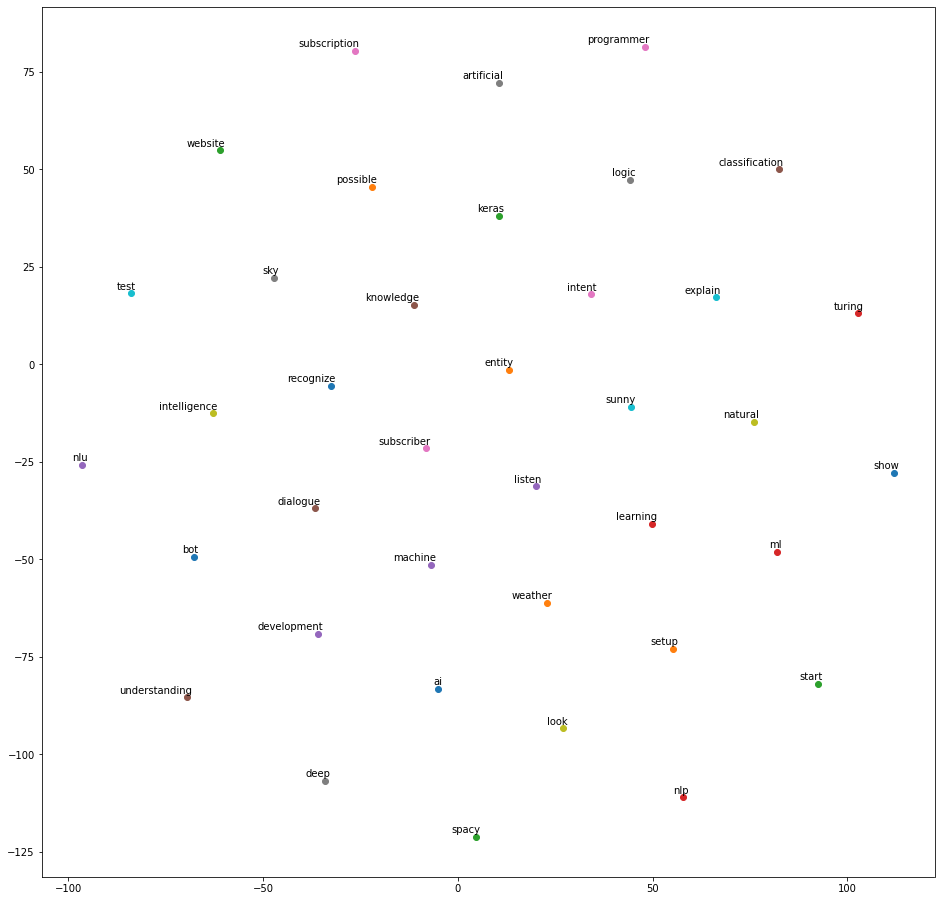

In [83]:
labels, tokens = get_tokens_and_labels_emb(embedding_words, popular_words)
tsne_fit_and_plot(tokens=tokens, labels=labels)

#### t-SNE Dimensionality reduction
As we can see, reducing a 100 dimension vector so much doesn't seem to make much sense, and thus it's better to look at the words closest to target word.

In [96]:
print_sorted_words('weather', metric='cosine')

Distance from 'weather':
0.000 - weather
0.292 - rain
0.363 - cold
0.367 - sunny
0.394 - humid
0.402 - forecast
0.406 - temperature
0.410 - meteorological
0.423 - cool
0.436 - hot


In [93]:
print_sorted_words('classification', metric='cosine')

Distance from 'classification':
0.000 - classification
0.497 - type
0.525 - system
0.530 - configuration
0.556 - proper
0.557 - course
0.559 - humid
0.572 - race
0.576 - list
0.578 - different


In [97]:
print_sorted_words('programmer', metric='cosine')

Distance from 'programmer':
0.000 - programmer
0.383 - software
0.430 - engineer
0.475 - developer
0.499 - creator
0.505 - scientist
0.518 - setup
0.519 - designer
0.522 - lets
0.532 - master
